# Convolutional Neural Network 




Convolutional Neural Network for classifying handwritten digits.

The network will be composed of 

	• At least two convolutional layers with activation + pooling.
	• Example: Conv(1→32, 3×3) → ReLU → MaxPool → Conv(32→64, 3×3) → ReLU → MaxPool → FC → Softmax.
	• Train with cross-entropy loss.


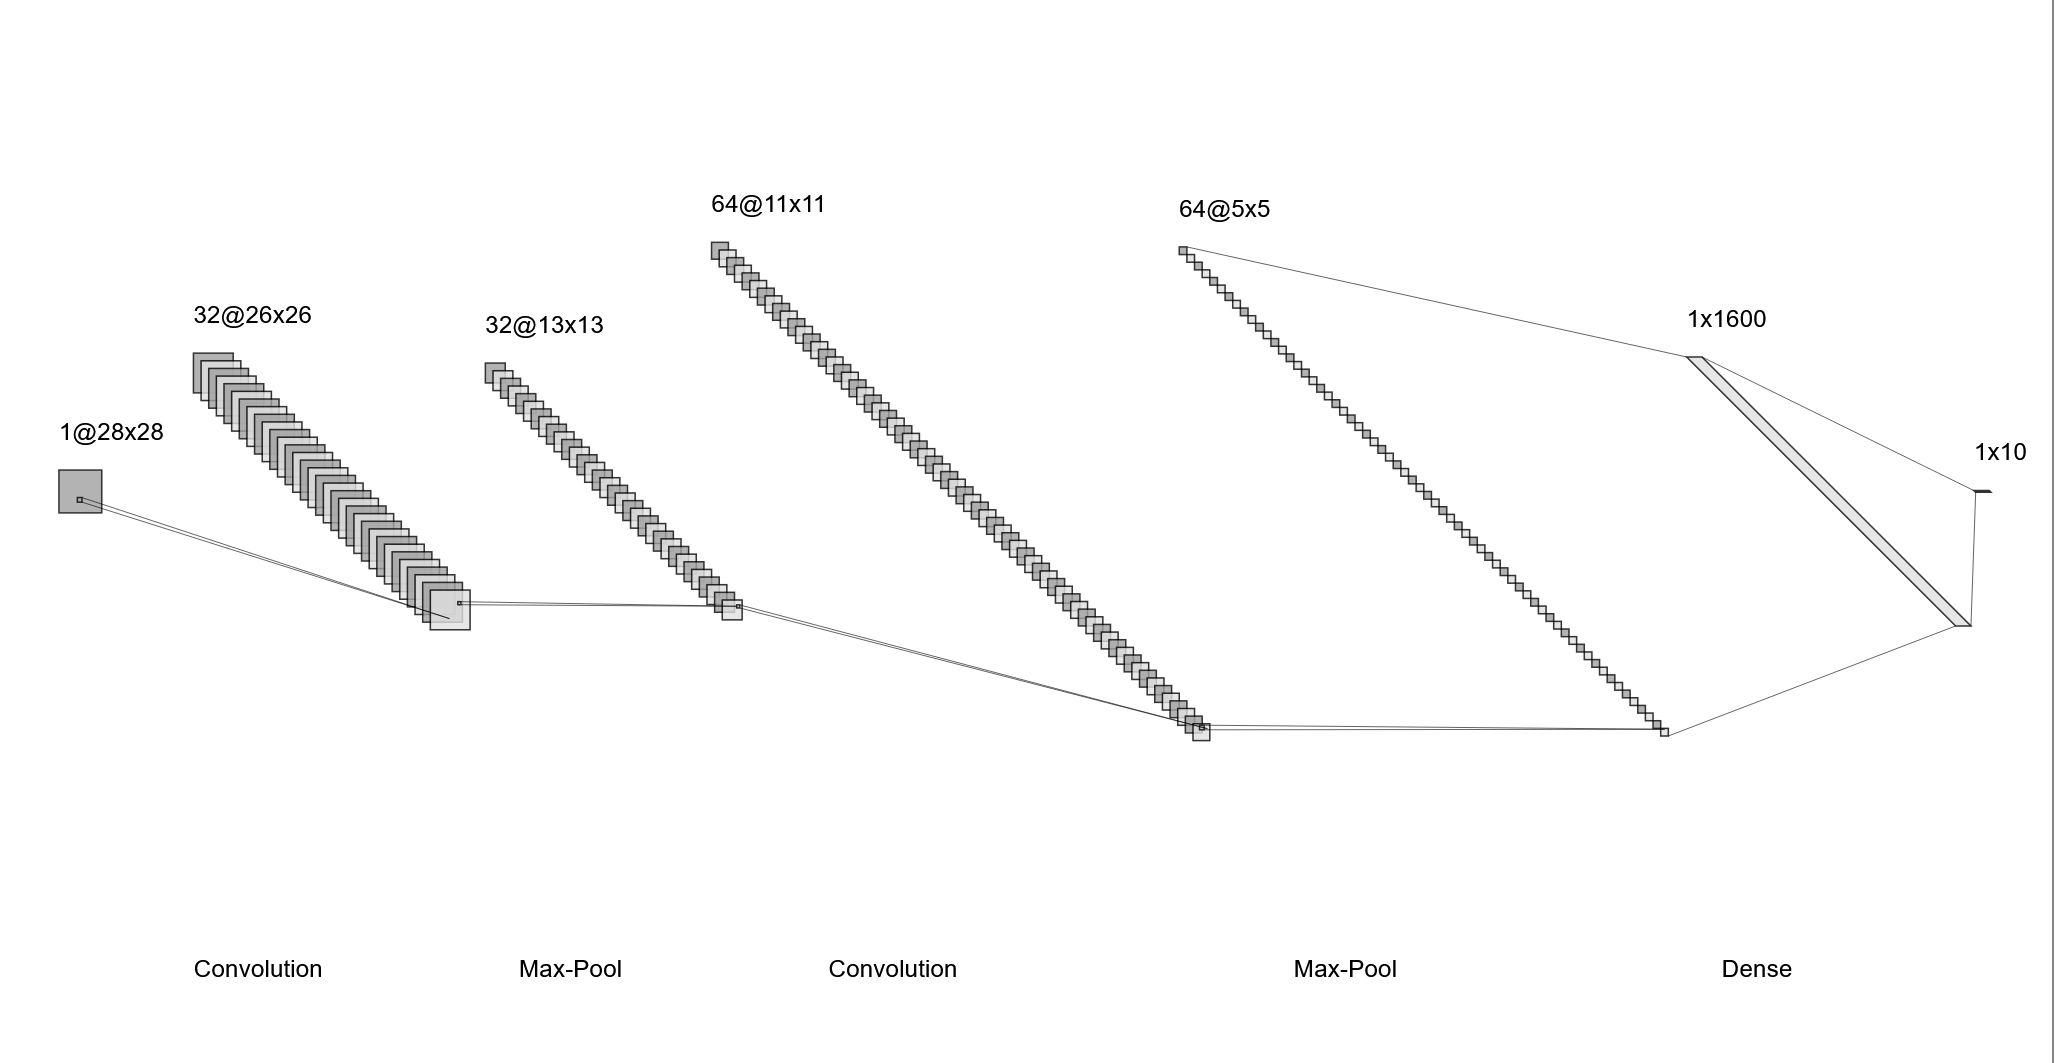

Diagram: https://alexlenail.me/NN-SVG/LeNet.html

AlexNet representation:


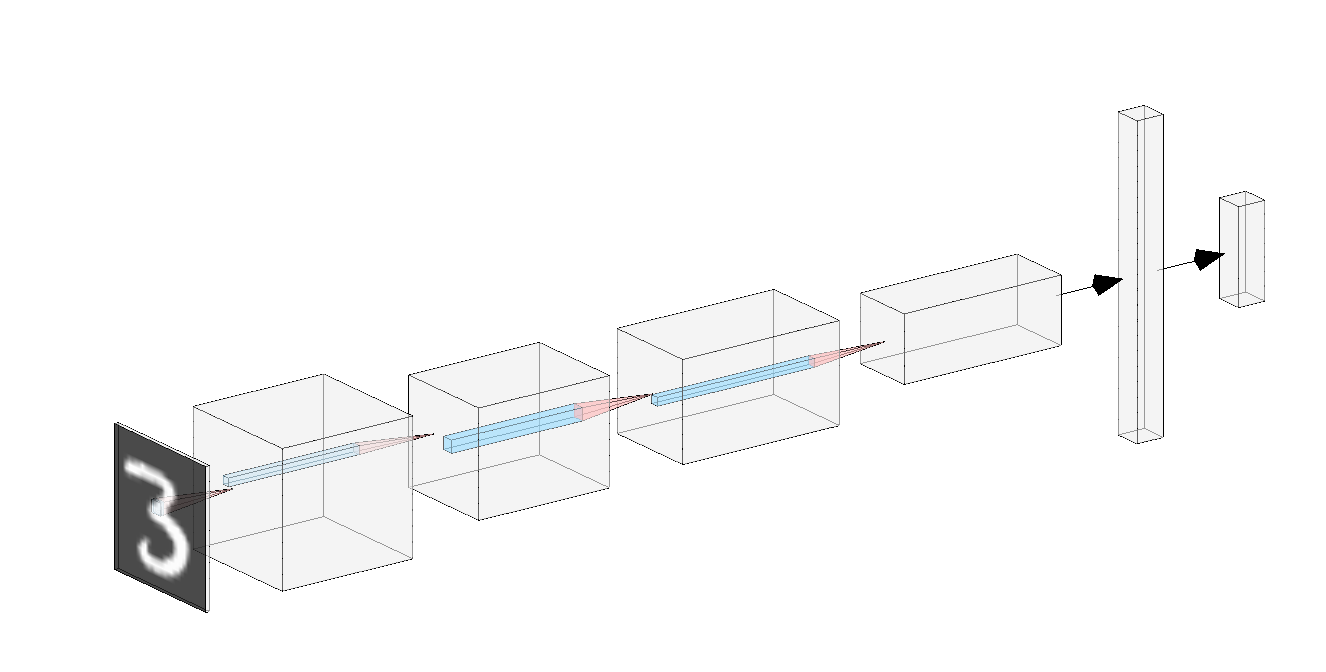


Diagram: https://alexlenail.me/NN-SVG/AlexNet.html

Sources:
https://docs.pytorch.org/tutorials/beginner/nn_tutorial.html

Momentum:
https://blog.dailydoseofds.com/p/an-intuitive-and-visual-demonstration
https://distill.pub/2017/momentum/
chatgpt gpt-5  and gemini to clarify concepts.


chatgpt gpt-5 and GPT-4o for help with LaTeX formatting, debugging, and evaluation function.

In [1]:
# import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import sklearn.metrics
from utilities import train_test_split
from torch import nn

In [2]:
# load and split data into train and test set

# load the numpy array and convert it to a tensor
data = np.load("images_array.npy")
labels = np.load("labels_array.npy")

# data has shape (60_000, 784)
# labels has shape (60_000)
data = torch.from_numpy(data)
labels = torch.from_numpy(labels)

# convert data to float 32 and do a train test split
data = data.type(torch.float32)
# convert labels into torch.long type for use in torch 
labels = labels.type(torch.long)

data = data.reshape(-1, 28, 28)
x_train, y_train, x_test, y_test = train_test_split(data, labels, train_size=0.7)

# dimensions of training data:
n, rows, cols = x_train.shape

# reshape x_train and x_test from (samples, height, width) to (samples, channels, height, width)
# for input into the model 
x_train = x_train.view(-1, 1, 28, 28)
x_test = x_test.view(-1, 1, 28, 28)

In [3]:
model = nn.Sequential(
    nn.Conv2d(1, 32, 3),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Flatten(),
    nn.Linear(64*25, 10),
)

In [4]:
# define a class to create a model

class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        # define network structure

        self.layers = nn.Sequential(
            nn.Conv2d(1, 32, 3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            # Fully connected layer
            nn.Flatten(),
            nn.Linear(64*25, 10),
        )

    def forward(self, x):
        y = self.layers(x)
        return y

In [5]:
# Function provided by chatgpt to see the shape of the data after each layer for debugging purposes.
class ShapeTracer(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, x):
        print(f"Input shape: {x.shape}")
        for i, layer in enumerate(self.model):
            x = layer(x)
            print(f"After layer {i} ({layer.__class__.__name__}): {x.shape}")
        return x


In [6]:
# Shapes of data after passing throuhg each layer
traced_model = ShapeTracer(model)

x = torch.randn(1, 1, 28, 28)
out = traced_model(x)

Input shape: torch.Size([1, 1, 28, 28])
After layer 0 (Conv2d): torch.Size([1, 32, 26, 26])
After layer 1 (ReLU): torch.Size([1, 32, 26, 26])
After layer 2 (MaxPool2d): torch.Size([1, 32, 13, 13])
After layer 3 (Conv2d): torch.Size([1, 64, 11, 11])
After layer 4 (ReLU): torch.Size([1, 64, 11, 11])
After layer 5 (MaxPool2d): torch.Size([1, 64, 5, 5])
After layer 6 (Flatten): torch.Size([1, 1600])
After layer 7 (Linear): torch.Size([1, 10])


In [7]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=.8)

In [8]:
criterion = nn.CrossEntropyLoss()

In [9]:
def train_model(model, optimizer, criterion, bs = 32, num_epochs=5):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i in range((n - 1) // bs + 1):
            start_i = i * bs
            end_i = start_i + bs
            images = x_train[start_i:end_i] # get batch size number of samples
            labels = y_train[start_i:end_i]
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {running_loss/(i+1):.4f}")

I reinitialized and trained the model multiple times, and noticed that the average loss per batch in the first epoch is in the range of [0.3, 0.5]. This model uses SGD optimizer with a momentum of 0.8 and a learning rate of 0.001. In contrast model2 start with a high loss (close to 1) with a momentum of 0.9, and the loss even goes up and down.

In [10]:
train_model(model, optimizer, criterion, num_epochs= 40)

Epoch 1, Loss: 0.4391
Epoch 2, Loss: 0.5028
Epoch 3, Loss: 0.3740


KeyboardInterrupt: 

In [11]:

def evaluate(model, x_data, y_data):
    model.eval()
    with torch.no_grad():
        outputs = model(x_data)
        _, predicted = torch.max(outputs.data, 1)
        total = y_data.size(0)
        correct = (predicted == y_data).sum().item()
    return correct / total

In [12]:
evaluate(model, x_train, y_train) # performance on training set

KeyboardInterrupt: 

In [ ]:
evaluate(model, x_test, y_test) # performance on testing set

0.8367222222222223

It is important to try understand the interplay of different hyperparameters for the network. In this case, model2 is the same model as the first one. But if we increase the momentum in SGD by 0.1, we observe divergent behavior.

Momentum will allow us to move faster in the direction that we saw a decrease in the loss. However, this can also make the loss ping pong between different values wtithout settling in a minimum, just like having a large step size. Momentum can help the loss converge faster to a minimum, but it also means we can overshoot if the step size is too high. 

Below is the result of running this model with a momentum of 0.9 with 10 epochs


Standard (classical) momentum (using velocity v)
\begin{aligned}
g_t &= \nabla_w \mathcal{L}(w_{t-1}) \\
v_t &= \mu\, v_{t-1} - \alpha\, g_t \quad\text{with } v_0 = 0\\
w_t &= w_{t-1} + v_t
\end{aligned}

where

$\alpha$: step size

 $\mu$: momentum coefficient

 $v_t$: velocity or accumulated update direction

In [ ]:
model2 = ConvNet()
optimizer2 = torch.optim.SGD(model2.parameters(), lr=0.001, momentum=0.9)
criterion2 = nn.CrossEntropyLoss()

Model 2 showing increasing loss as epochs go up due to high momentum.

In [ ]:
train_model(model2, optimizer2, criterion2, num_epochs=10)
evaluate(model2, x_train, y_train)

32
Epoch 1, Loss: 0.7226
Epoch 2, Loss: 0.9345
Epoch 3, Loss: 1.0569
Epoch 4, Loss: 1.2068
Epoch 5, Loss: 1.3955
Epoch 6, Loss: 1.4714
Epoch 7, Loss: 1.5313
Epoch 8, Loss: 2.3326
Epoch 9, Loss: 2.3109
Epoch 10, Loss: 2.3154


0.0992289189128431

In [ ]:
evaluate(model2, x_test, y_test)

0.3268888888888889

In [20]:
model3 = ConvNet()
optimizer3 = torch.optim.SGD(model3.parameters(), lr = 0.01, momentum=0.0)


In [27]:
train_model(model3, optimizer3, criterion, bs = 256, num_epochs=100)

Epoch 1, Loss: 0.0372
Epoch 2, Loss: 0.0370
Epoch 3, Loss: 0.0368
Epoch 4, Loss: 0.0366
Epoch 5, Loss: 0.0365
Epoch 6, Loss: 0.0363
Epoch 7, Loss: 0.0361
Epoch 8, Loss: 0.0359
Epoch 9, Loss: 0.0357
Epoch 10, Loss: 0.0356
Epoch 11, Loss: 0.0354
Epoch 12, Loss: 0.0352
Epoch 13, Loss: 0.0351
Epoch 14, Loss: 0.0349
Epoch 15, Loss: 0.0347
Epoch 16, Loss: 0.0346
Epoch 17, Loss: 0.0344
Epoch 18, Loss: 0.0342
Epoch 19, Loss: 0.0341
Epoch 20, Loss: 0.0339
Epoch 21, Loss: 0.0338
Epoch 22, Loss: 0.0336
Epoch 23, Loss: 0.0335
Epoch 24, Loss: 0.0333
Epoch 25, Loss: 0.0332
Epoch 26, Loss: 0.0330
Epoch 27, Loss: 0.0329
Epoch 28, Loss: 0.0327
Epoch 29, Loss: 0.0326
Epoch 30, Loss: 0.0324
Epoch 31, Loss: 0.0323
Epoch 32, Loss: 0.0321
Epoch 33, Loss: 0.0320
Epoch 34, Loss: 0.0319
Epoch 35, Loss: 0.0317
Epoch 36, Loss: 0.0316
Epoch 37, Loss: 0.0315
Epoch 38, Loss: 0.0313
Epoch 39, Loss: 0.0312
Epoch 40, Loss: 0.0310
Epoch 41, Loss: 0.0309
Epoch 42, Loss: 0.0308
Epoch 43, Loss: 0.0306
Epoch 44, Loss: 0.03

In [28]:
# performance on the training set
evaluate(model3, x_train, y_train)

0.9692758193490257

In [29]:
# performance on the test set
evaluate(model3, x_test, y_test)

0.9653888888888889

model 3 shows an accuracy of $83.22\%$ on the test set